In [1]:
from dotenv import load_dotenv
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

r = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
r2 = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})

In [3]:
visits = pd.DataFrame(r.json())
registrations = pd.DataFrame(r2.json())

In [4]:
visits = visits[visits['platform'] != 'bot']
visits['datetime'] = pd.to_datetime(visits['datetime'])
last_date = visits.groupby('visit_id')['datetime'].max().reset_index()
visits = pd.merge(last_date, visits, on=['visit_id', 'datetime'], how='left')
df1 = visits.groupby([pd.Grouper(key='datetime', freq='D'), 'platform']).agg({'visit_id': 'count'}).reset_index()

In [5]:
registrations['datetime'] = pd.to_datetime(registrations['datetime'])
df2 = registrations.groupby([pd.Grouper(key='datetime', freq='D'), 'platform']).agg({'user_id': 'count'}).reset_index()

In [6]:
df1.columns = ['date_group', 'platform', 'visits']
df2.columns = ['date_group', 'platform', 'registrations']
conv = pd.merge(df1, df2, on=['date_group', 'platform'], how='outer')
conv['conversion'] = conv['registrations'] / conv['visits'] * 100
conv.to_json('./conversion.json')
conv

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.606061
548,2023-08-30,web,1227,34,2.770986
549,2023-08-31,android,57,42,73.684211
550,2023-08-31,ios,50,36,72.000000


In [7]:
ads_raw = pd.read_csv('ads.csv')
ads_raw['date'] = pd.to_datetime(pd.to_datetime(ads_raw['date']).dt.date)
# ads.groupby(pd.Grouper(key='date', freq='D')).agg({'utm_campaign': 'count', 'cost': 'sum'}).sort_values('utm_campaign', ascending=False).reset_index()

In [8]:
conv_edit = conv.groupby('date_group')[['visits', 'registrations']].sum().reset_index()
ads = pd.merge(conv_edit, ads_raw, left_on='date_group', right_on='date', how='left')
ads['cost'] = ads['cost'].fillna(0)
ads = ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
ads['date_group'] = ads['date_group'].dt.date
ads.to_json('./ads.json')
ads

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,376,87,212.0,advanced_algorithms_series
1,2023-03-02,613,106,252.0,advanced_algorithms_series
2,2023-03-03,683,107,202.0,advanced_algorithms_series
3,2023-03-04,647,159,223.0,advanced_algorithms_series
4,2023-03-05,707,115,265.0,advanced_algorithms_series
...,...,...,...,...,...
179,2023-08-27,795,88,222.0,intro_to_python_course
180,2023-08-28,635,83,223.0,intro_to_python_course
181,2023-08-29,1268,143,190.0,intro_to_python_course
182,2023-08-30,1328,101,109.0,intro_to_python_course


In [9]:
current_dir = os.getcwd() 
charts_folder = os.path.join(current_dir, 'charts')

if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)

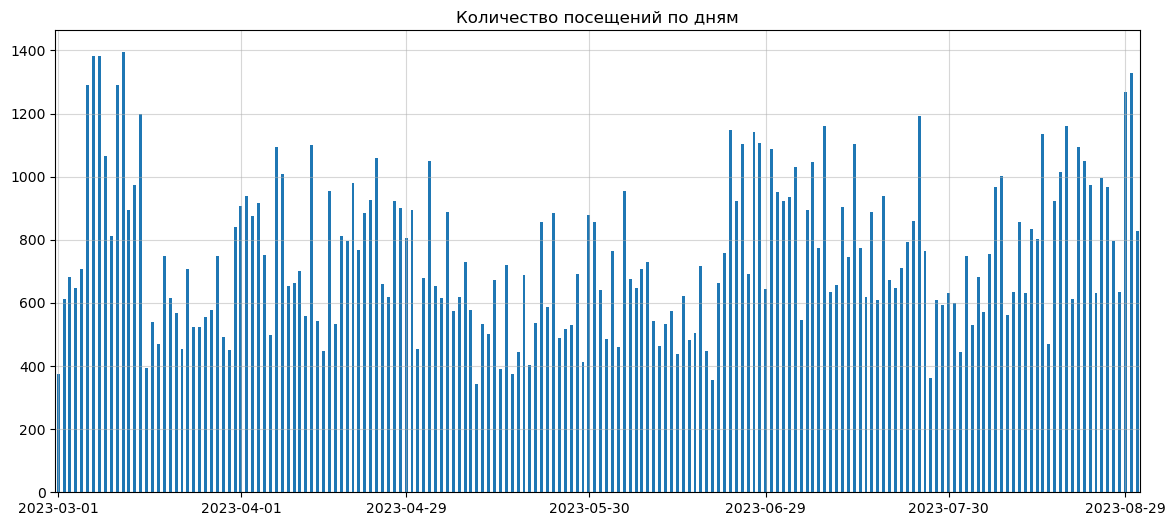

In [36]:
fig, ax = plt.subplots(figsize=(14, 6))
ads.plot(kind='bar', x='date_group', y='visits', ax=ax, legend=False)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.title('Количество посещений по дням')
ax.set_xlabel('')
plt.xticks(rotation=0)
plt.grid(alpha=0.5)
plt.savefig('./charts/total_visits.png')

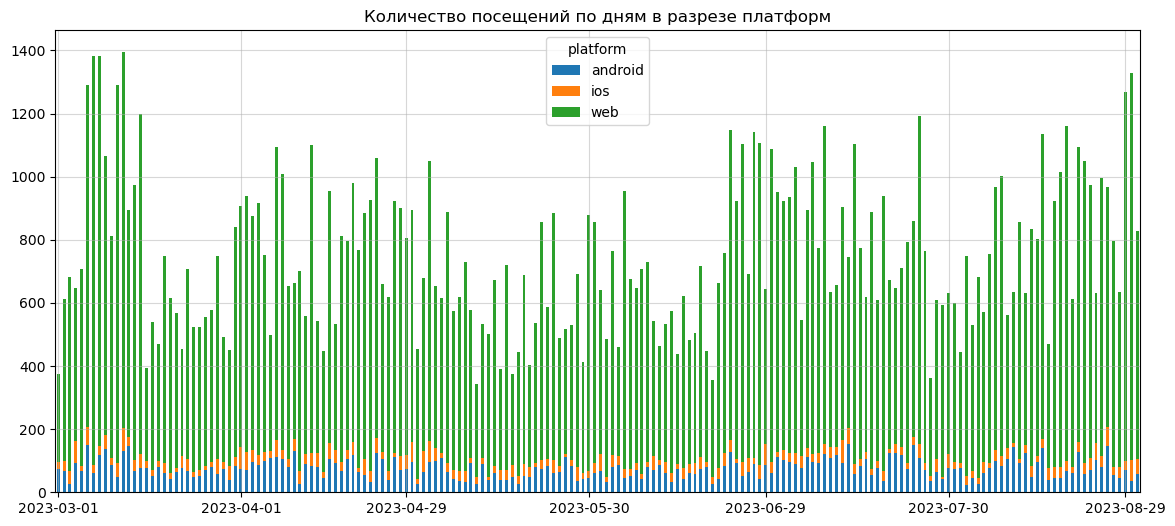

In [11]:
graph2 = conv.pivot(index='date_group', columns='platform', values='visits')
graph2.index = graph2.index.date
fig, ax = plt.subplots(figsize=(14, 6))
graph2.plot(kind='bar', stacked=True, ax=ax)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.set_title('Количество посещений по дням в разрезе платформ')
plt.xticks(rotation=0)
ax.grid(alpha=0.5)
plt.savefig('./charts/total_visits_platform.png')

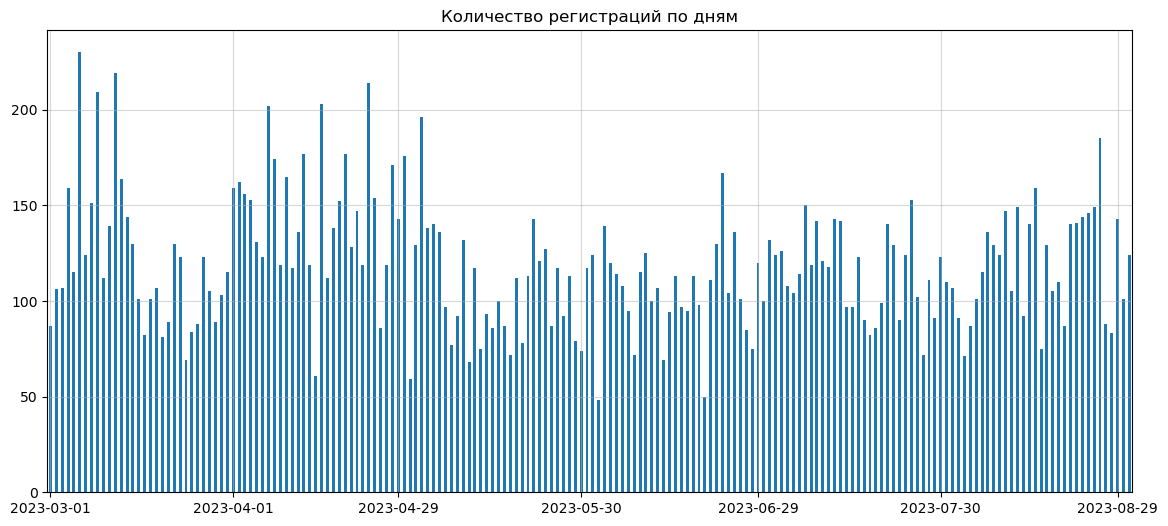

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))
ads.plot(kind='bar', x='date_group', y='registrations', ax=ax, legend=False)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.title('Количество регистраций по дням')
ax.set_xlabel('')
plt.xticks(rotation=0)
plt.grid(alpha=0.5)
plt.savefig('./charts/total_registrations.png')

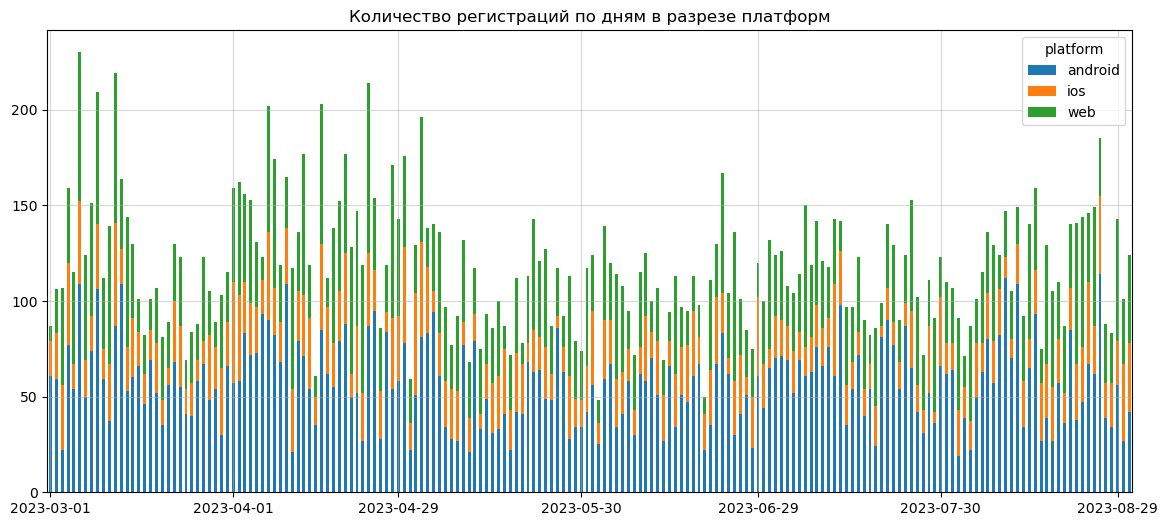

In [13]:
graph4 = conv.pivot(index='date_group', columns='platform', values='registrations')
graph4.index = graph4.index.date
fig, ax = plt.subplots(figsize=(14, 6))
graph4.plot(kind='bar', stacked=True, ax=ax)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.set_title('Количество регистраций по дням в разрезе платформ')
plt.xticks(rotation=0)
ax.grid(alpha=0.5)
plt.savefig('./charts/total_registrations_platform.png')

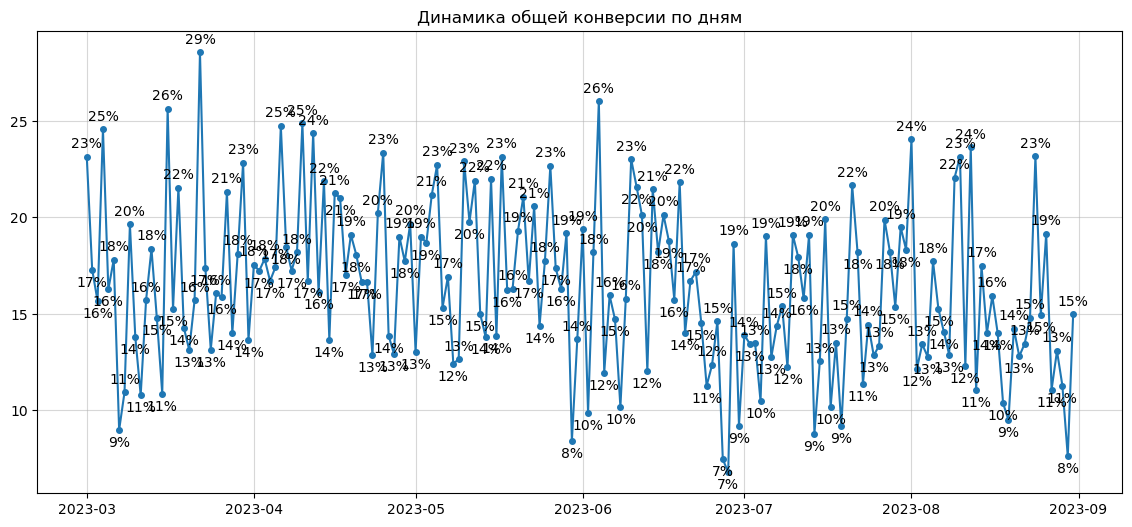

In [14]:
graph5 = ads[['date_group', 'visits', 'registrations']].copy()
graph5['conversion'] = graph5['registrations'] / graph5['visits'] * 100
fig, ax = plt.subplots(figsize=(14, 6))
graph5.plot(kind='line', x='date_group', y='conversion', ax=ax, legend=False, marker='o', markersize=4)
previous_conversion = None
for x, y in zip(graph5['date_group'], graph5['conversion']):
    if previous_conversion is not None:
        if y < previous_conversion:
            va = 'top'
        else:
            va = 'bottom'
    else:
        va = 'bottom'
    plt.text(x, y + 0.3 if va == 'bottom' else y - 0.3, f'{y:.0f}%', ha='center', va=va)
    previous_conversion = y
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.title('Динамика общей конверсии по дням')
ax.set_xlabel('')
plt.xticks(rotation=0)
plt.grid(alpha=0.5)
plt.savefig('./charts/total_conv.png')

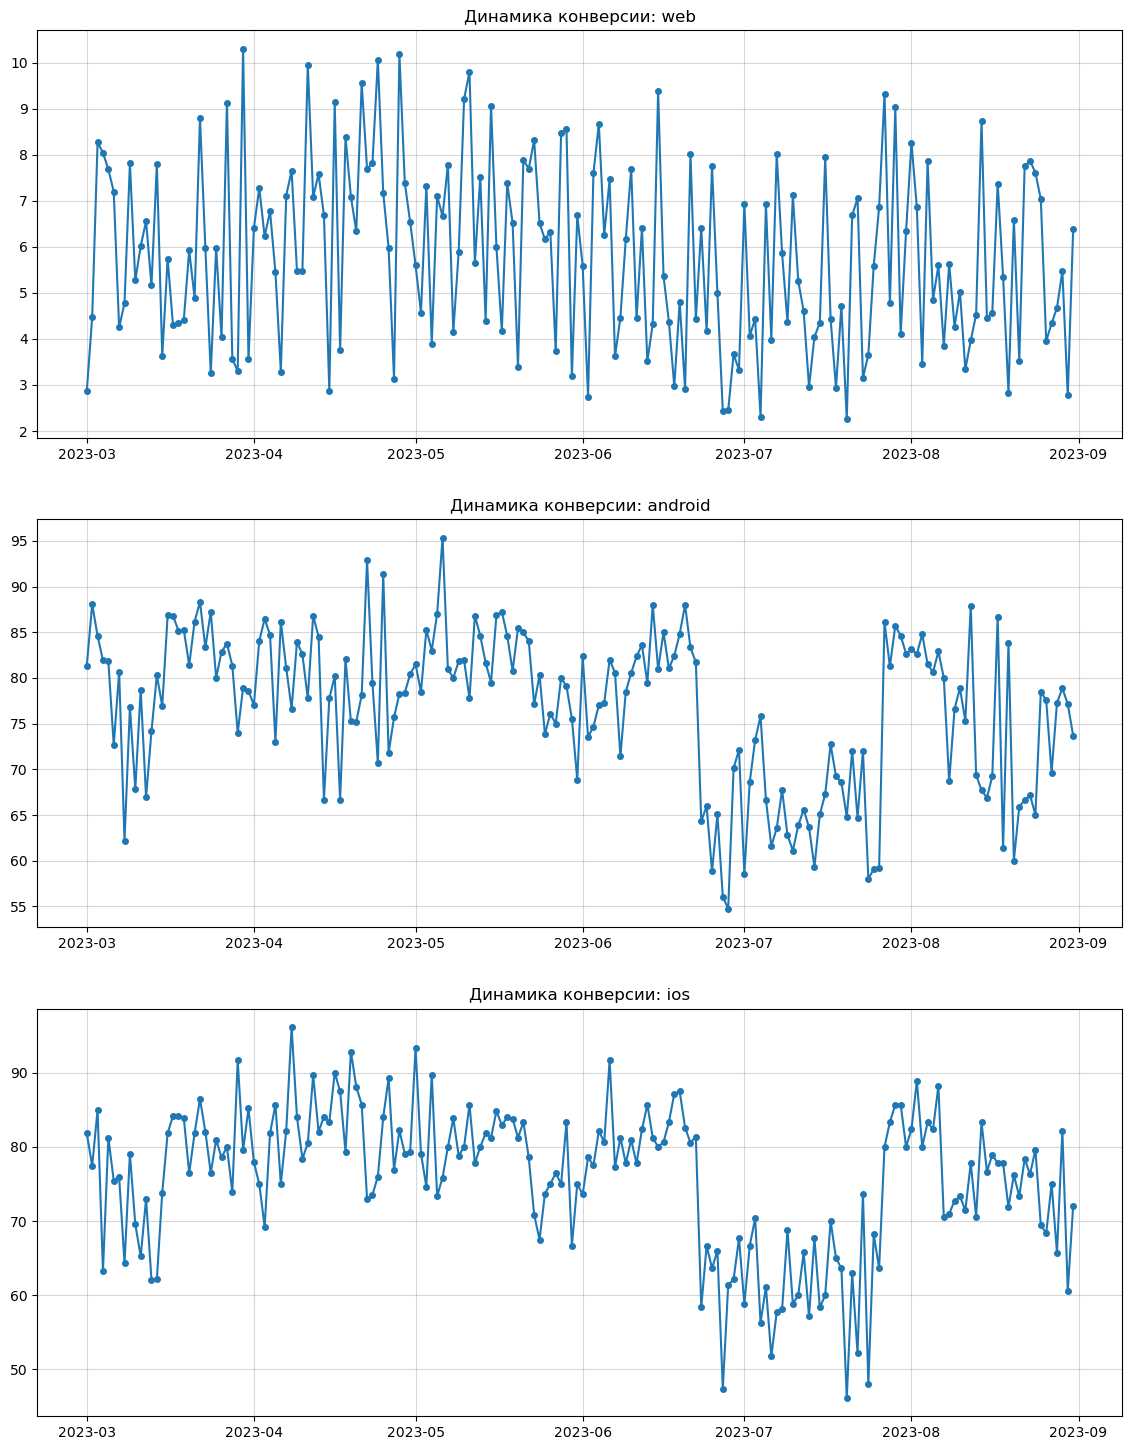

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
for i, platform in enumerate(['web', 'android', 'ios']):
    graph6 = conv[conv['platform'] == platform]
    axes[i].plot(graph6['date_group'], graph6['conversion'], marker='o', markersize=4)
    axes[i].set_title(f'Динамика конверсии: {platform}')
    axes[i].grid(alpha=0.5)
plt.savefig('./charts/total_conv_platform.png')

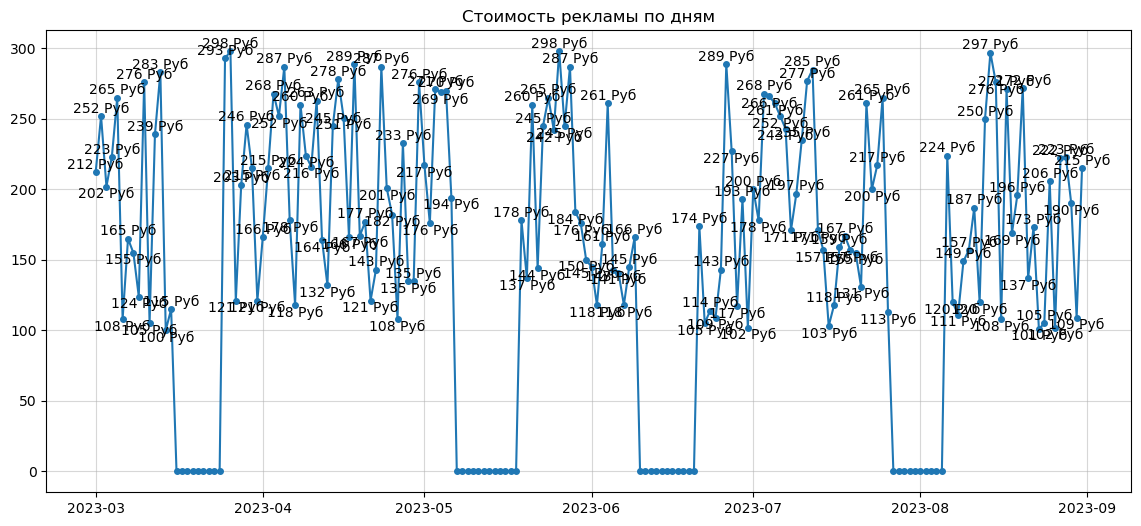

In [16]:
fig, ax = plt.subplots(figsize=(14, 6))
ads.plot(kind='line', x='date_group', y='cost', ax=ax, legend=False, marker='o', markersize=4)
previous_conversion = None
for x, y in zip(ads['date_group'], ads['cost']):
    if y != 0:
        if previous_conversion is not None:
            if y < previous_conversion:
                va = 'top'
            else:
                va = 'bottom'
        else:
            va = 'bottom'
        plt.text(x, y + 0.3 if va == 'bottom' else y - 0.3, f'{y:.0f} Руб', ha='center', va=va)
    previous_conversion = y
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.title('Стоимость рекламы по дням')
ax.set_xlabel('')
plt.xticks(rotation=0)
plt.grid(alpha=0.5)
plt.savefig('./charts/ads_cost.png')

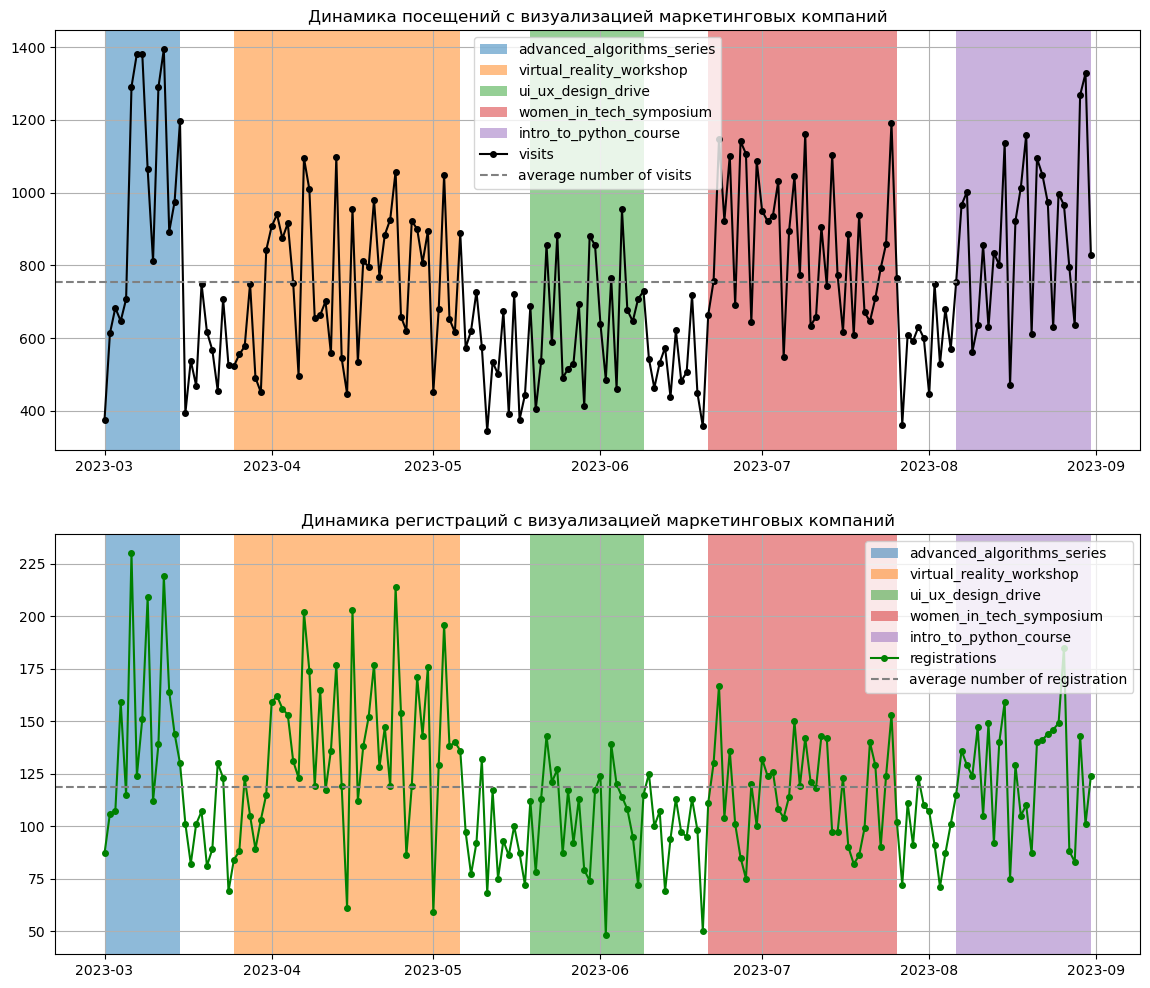

In [17]:
graph8 = ads.groupby('utm_campaign').agg({'date_group': ['min', 'max']})
graph8.columns = ['start_ads', 'end_ads']
graph8 = graph8.sort_values('end_ads').reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 12))
for i, name, start, end in zip(graph8.index, graph8['utm_campaign'], graph8['start_ads'], graph8['end_ads']):
    axes[0].axvspan(start, end, fc=plt.cm.tab10(i), alpha=0.5, label=name)
    axes[1].axvspan(start, end, fc=plt.cm.tab10(i), alpha=0.5, label=name)

axes[0].plot(ads['date_group'], ads['visits'], color='black', marker='o', markersize=4, label='visits')
axes[0].set_title('Динамика посещений с визуализацией маркетинговых компаний')
axes[0].axhline(ads['visits'].mean(), linestyle='--', color='gray', label='average number of visits')
axes[0].grid()
axes[0].legend()

axes[1].plot(ads['date_group'], ads['registrations'], color='green', marker='o', markersize=4, label='registrations')
axes[1].set_title('Динамика регистраций с визуализацией маркетинговых компаний')
axes[1].axhline(ads['registrations'].mean(), linestyle='--', color='gray', label='average number of registration')
axes[1].grid()
axes[1].legend()
plt.savefig('./charts/total.png')